In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
import torchvision
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import time
import numpy as np
import collections
import re
import random
import math

In [2]:
num_hiddens, num_heads = 100, 5
attention = utils.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [3]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

# 位置编码

![v52_1](../data/img/v52_1.png)

In [4]:

class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

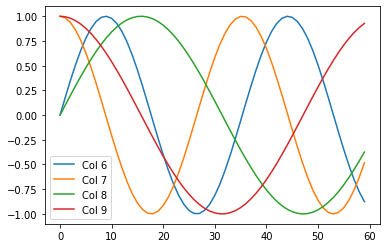

In [5]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
for i in range(6, 10):
    plt.plot(torch.arange(num_steps), P[0, :, i].T)
plt.legend([f'Col {d}' for d in torch.arange(6, 10)])

In [6]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


In [7]:
num = 16
for i in range(num):
    _pow_2 = int(math.log2(num))
    i_b = bin(i).lstrip('0b').rjust(_pow_2, '0')
    i_b_reverse = i_b[::-1]
    print(f'{i:>2}的二进制是：{i_b}, 反转，观察所有最后一位不是0的数字组成的轮廓：{i_b_reverse}')

 0的二进制是：0000, 反转，观察所有最后一位不是0的数字组成的轮廓：0000
 1的二进制是：0001, 反转，观察所有最后一位不是0的数字组成的轮廓：1000
 2的二进制是：0010, 反转，观察所有最后一位不是0的数字组成的轮廓：0100
 3的二进制是：0011, 反转，观察所有最后一位不是0的数字组成的轮廓：1100
 4的二进制是：0100, 反转，观察所有最后一位不是0的数字组成的轮廓：0010
 5的二进制是：0101, 反转，观察所有最后一位不是0的数字组成的轮廓：1010
 6的二进制是：0110, 反转，观察所有最后一位不是0的数字组成的轮廓：0110
 7的二进制是：0111, 反转，观察所有最后一位不是0的数字组成的轮廓：1110
 8的二进制是：1000, 反转，观察所有最后一位不是0的数字组成的轮廓：0001
 9的二进制是：1001, 反转，观察所有最后一位不是0的数字组成的轮廓：1001
10的二进制是：1010, 反转，观察所有最后一位不是0的数字组成的轮廓：0101
11的二进制是：1011, 反转，观察所有最后一位不是0的数字组成的轮廓：1101
12的二进制是：1100, 反转，观察所有最后一位不是0的数字组成的轮廓：0011
13的二进制是：1101, 反转，观察所有最后一位不是0的数字组成的轮廓：1011
14的二进制是：1110, 反转，观察所有最后一位不是0的数字组成的轮廓：0111
15的二进制是：1111, 反转，观察所有最后一位不是0的数字组成的轮廓：1111


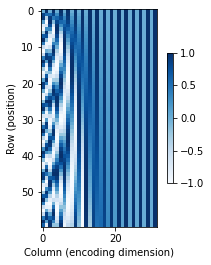

In [8]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
utils.show_heatmaps(P, xlabel='Column (encoding dimension)', ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')